In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Child Generation with GAN

In this project, I use Families in the Wild (FIW) dataset to train GAN to generate child images based on images of parents.

## 1. Creating data loader

In [2]:
import os
import random
from itertools import combinations
from PIL import Image
from torch.utils.data import DataLoader
import glob
from torchvision import transforms


class FIWCustomDataLoader:
    def __init__(self, csv_file, root_dir, img_dir="train-faces/train-faces", transform=None, child_gender='s'):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = os.path.join(root_dir, img_dir)
        self.child_gender = child_gender
        self.families = self._load_annotations(os.path.join(root_dir, csv_file))
        self.transform = transform
       

    def _load_annotations(self, csv_file):
        """Loads the CSV annotations into a more usable form."""
        data = pd.read_csv(csv_file)
        
        # pre-filter data
        allowed_relations = {'fs', 'ms', 'md', 'fd'}
        data = data[data.ptype.isin(allowed_relations)]
        data = data[data.fid1 == data.fid2]
        data["has_father"] = data.groupby('fid1')['ptype'].transform(lambda x: x.eq(f'f{self.child_gender}').any())
        data["has_mother"] = data.groupby('fid1')['ptype'].transform(lambda x: x.eq(f'm{self.child_gender}').any())
        data = data[data.has_father & data.has_mother]
        
        families = dict()
        for _, row in data.iterrows():
            family_id = row['fid1']
            if family_id not in families:
                families[family_id] = {
                    'mpath' : '',
                    'fpath': '',
                    'cpaths': set(),
                }
            if row['ptype'] == f'f{self.child_gender}':
                families[family_id]['fpath'] = row['p1']
                families[family_id]['cpaths'].add(row['p2'])
            if row['ptype'] == f'm{self.child_gender}':
                families[family_id]['mpath'] = row['p1']
                families[family_id]['cpaths'].add(row['p2'])
                    
        return families

    def __iter__(self):
        """Custom iterator to generate parent-child combinations family by family."""
        for family_id, family_paths in self.families.items():
            # Iterate through all the possible parent-child combinations
            m_imgs = glob.glob(os.path.join(self.img_dir, family_paths['mpath'])  + '/*.jpg')
            m_imgs += glob.glob(os.path.join(self.img_dir, family_paths['mpath'])  + '/*.png')
            f_imgs = glob.glob(os.path.join(self.img_dir, family_paths['fpath'])  + '/*.jpg')
            f_imgs += glob.glob(os.path.join(self.img_dir, family_paths['fpath'])  + '/*.png')
            c_imgs = []
            for p in family_paths['cpaths']:
                c_imgs += glob.glob(os.path.join(self.img_dir, p) + '/*.jpg')
                c_imgs += glob.glob(os.path.join(self.img_dir, p) + '/*.png')
            
            m_img = Image.open(m_imgs[0])
            f_img = Image.open(f_imgs[0])
            c_img = Image.open(c_imgs[0])

            if self.transform:
                m_img = self.transform(m_img)
                f_img = self.transform(f_img)
                c_img = self.transform(c_img)

            yield m_img, f_img, c_img


# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the custom data loader
custom_loader = FIWCustomDataLoader(csv_file='train-pairs.csv', 
                                    root_dir='/kaggle/input/families-in-the-wild', 
                                    transform=transform)

# Example of iterating through the loader
m_img, f_img, c_img = next(iter(custom_loader))

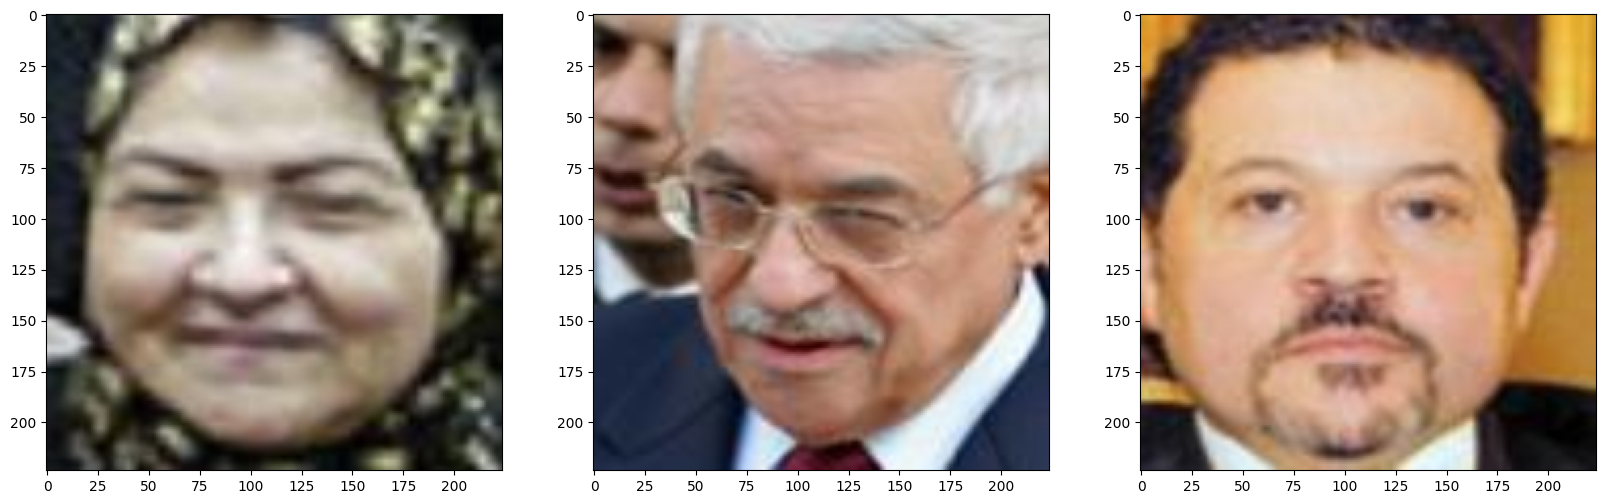

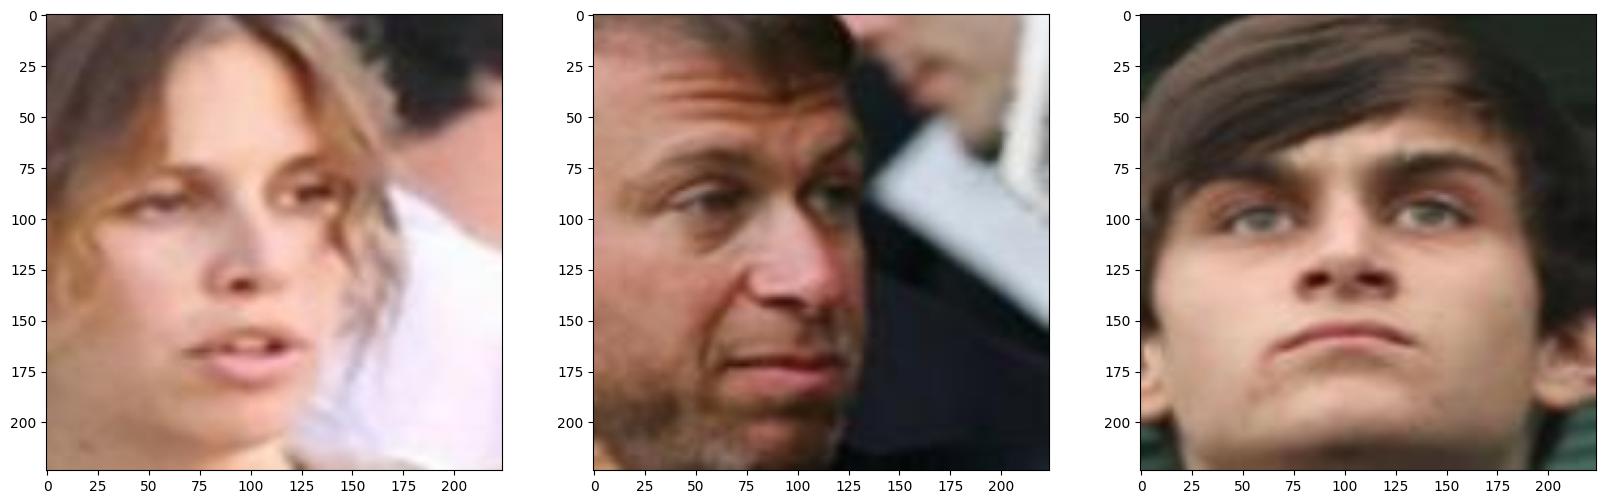

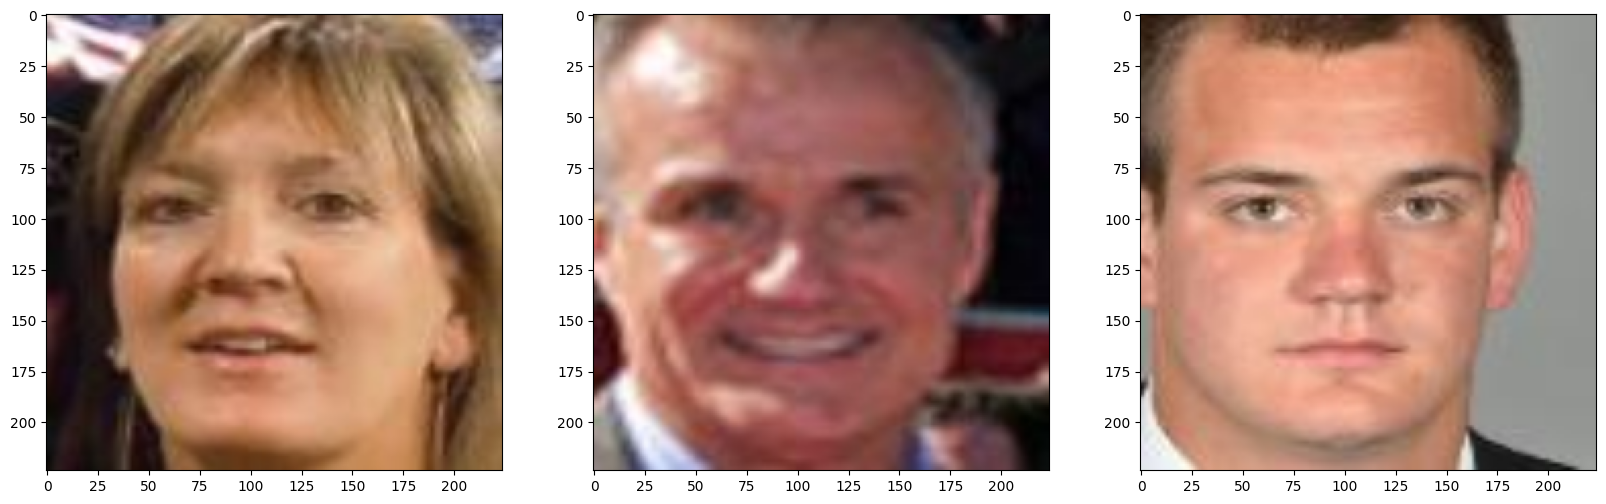

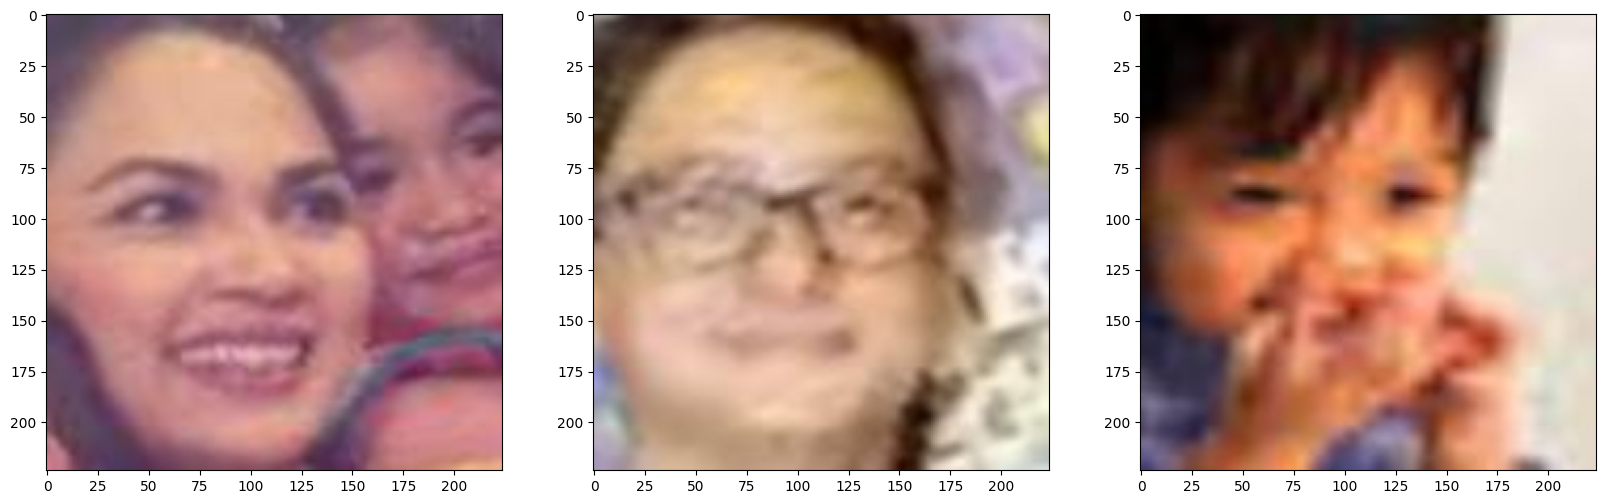

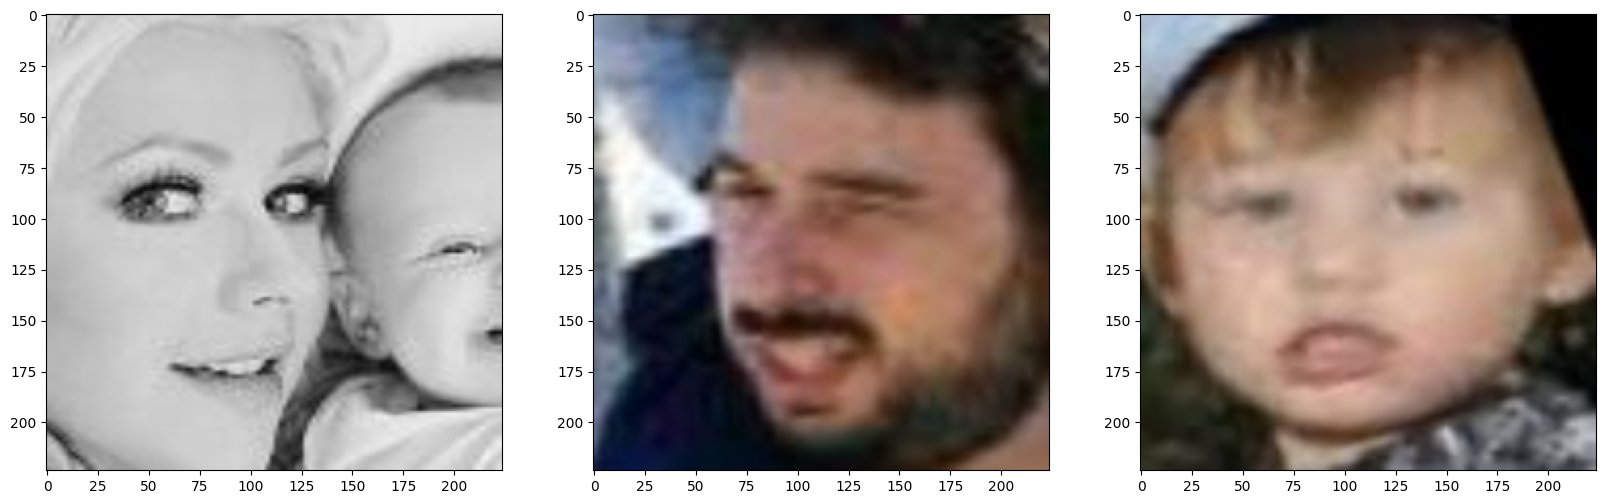

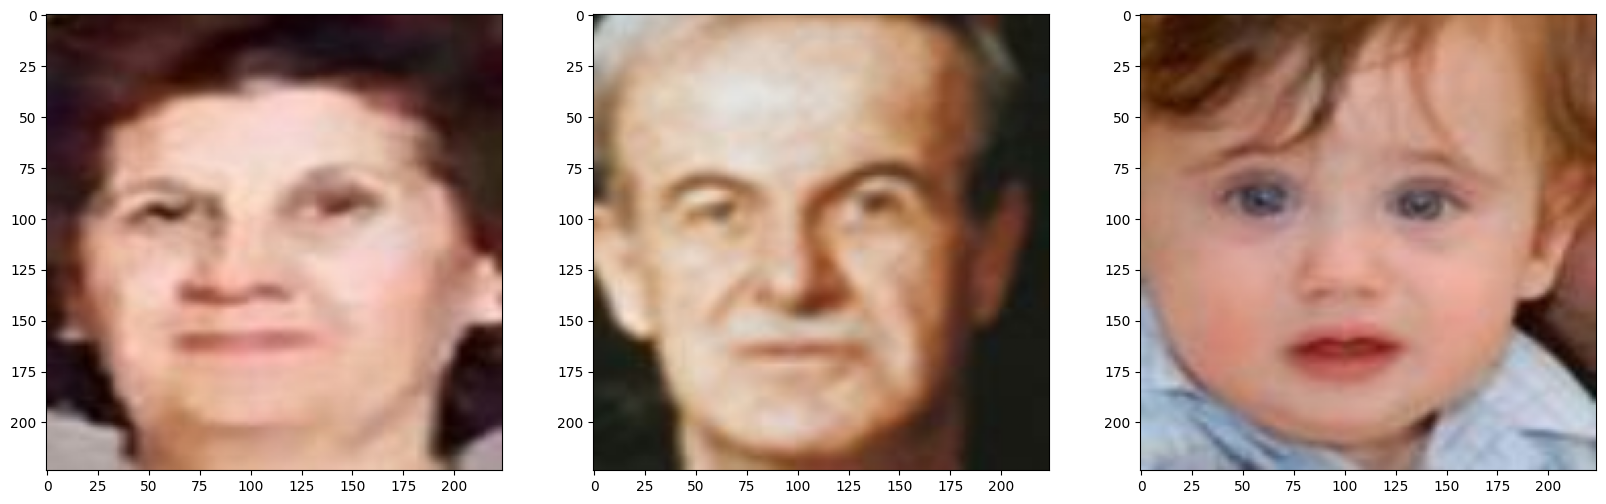

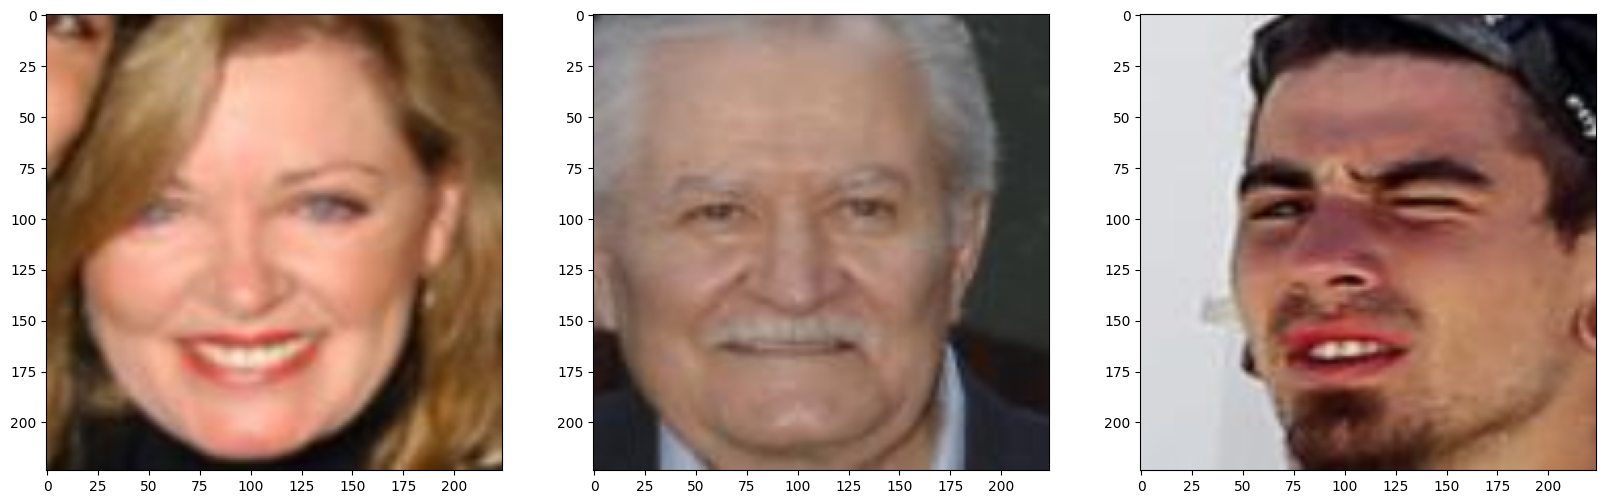

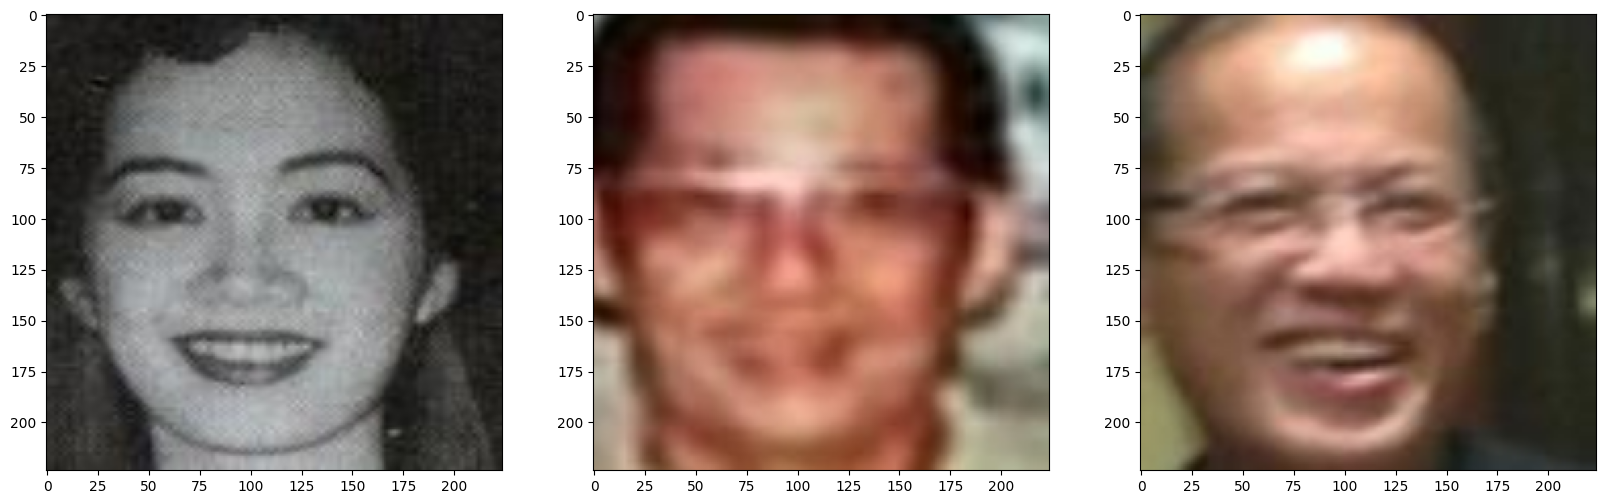

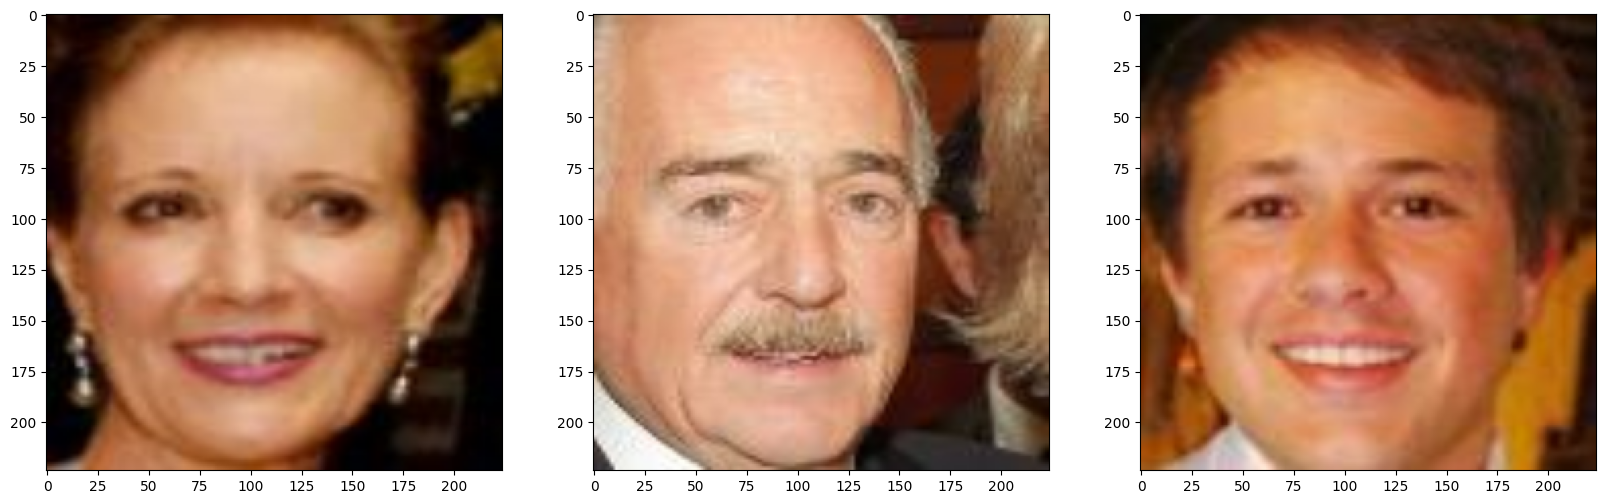

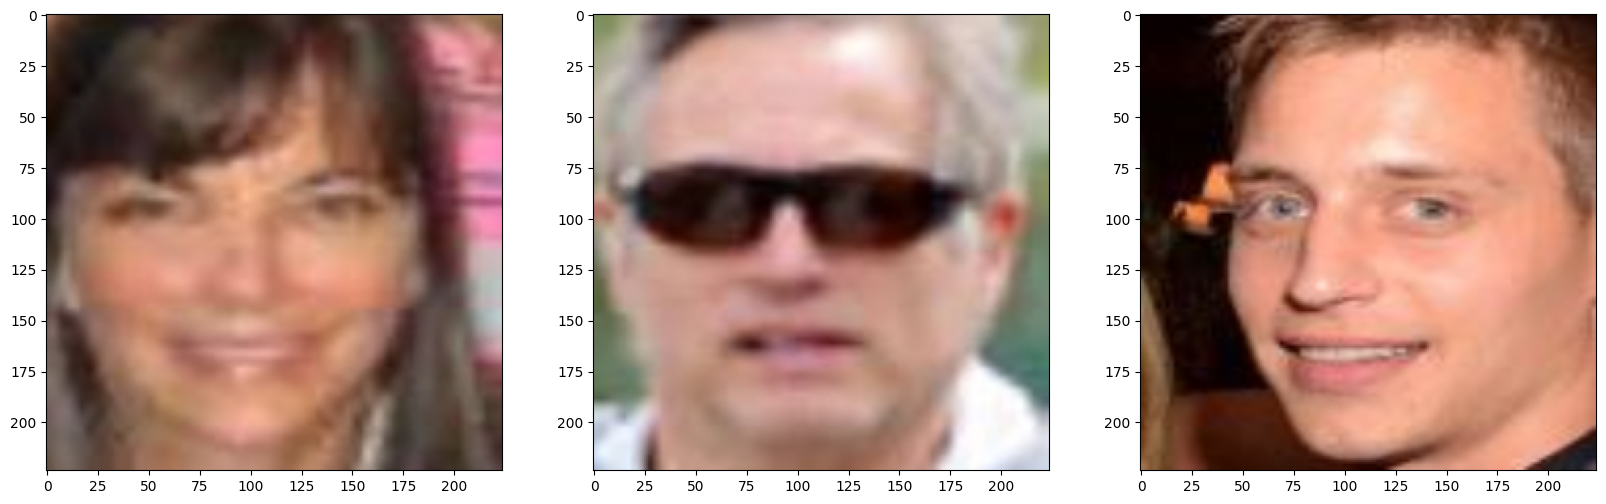

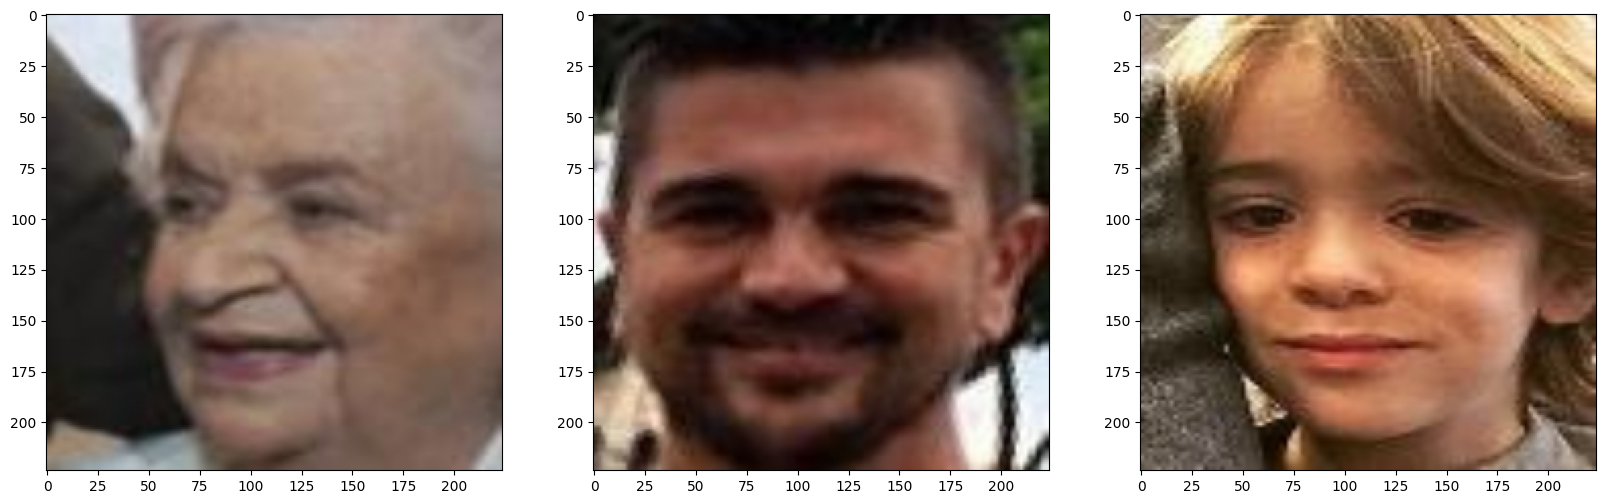

In [3]:
import matplotlib.pyplot as plt

def show_triple(m_img, f_img, c_img):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 9))
    axs[0].imshow(m_img.permute(1, 2, 0))
    axs[1].imshow(f_img.permute(1, 2, 0))
    axs[2].imshow(c_img.permute(1, 2, 0))

i = 0
for m_img, f_img, c_img in custom_loader:
    show_triple(m_img, f_img, c_img)
    i += 1
    if i > 10:
        break